# Topic: Histopathologic Cancer Detection

This task is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).PCam is highly interesting for both its size, simplicity to get started on, and approachability. 

# Acknowledgements
Kaggle is hosting this competition for the machine learning community to use for fun and practice. This dataset was provided by Bas Veeling, with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak.

I download the official Pcam dataset from GitHub. The data is provided under the CC0 License, following the license of Camelyon16.

Here are the reference of following papers:

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

Photo by Ousa Chea

# Citation
Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook

# Import libraries

import all the libraries we need.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

/Users/songruiming/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#  Brief description of the problem and data

Use the head()/describe()/info() functions to see what the data look like.

In [5]:
df = pd.read_csv('./input/histopathologic-cancer-detection/train_labels.csv')
df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [6]:
df.describe()

label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [8]:
print('Ratio labels : ', sum(df['label'].values)/len(df))
img = plt.imread("./input/histopathologic-cancer-detection/train/"+df.iloc[0]['id']+'.tif')
print('Images shape', img.shape)

Ratio labels :  0.40503124644926713
Images shape (96, 96, 3)


# Exploratory Data Analysis (EDA)

As we can see above, there are 220025 entries, and raio labels is 0.405, image shape is (96,96,3)

Next we see some pictures.

0


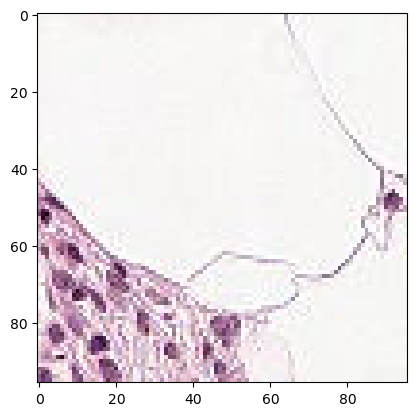

1


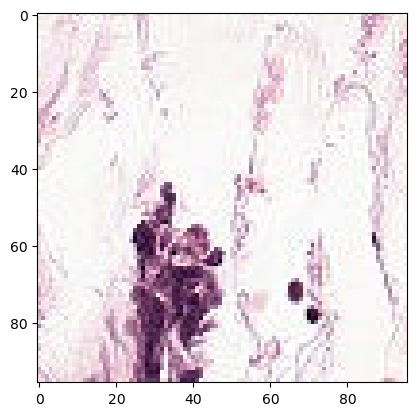

0


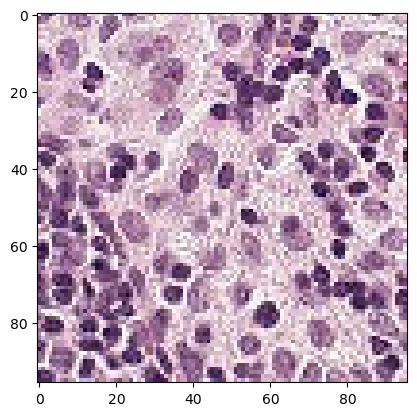

0


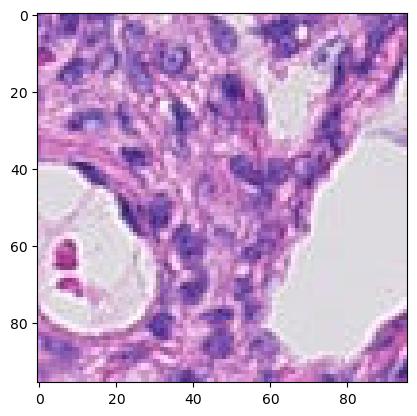

0


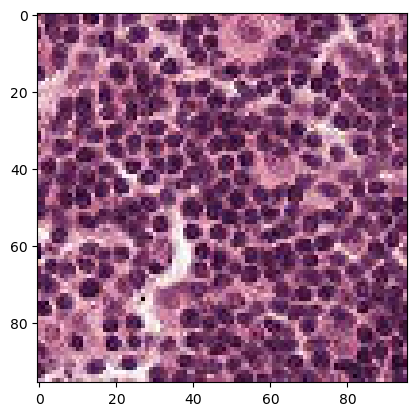

In [9]:
for i in range(5):
    img = plt.imread("./input/histopathologic-cancer-detection/train/"+df.iloc[i]['id']+'.tif')
    print(df.iloc[i]['label'])
    plt.imshow(img)
    plt.show()

Next we check the distribution of labels and plot the histograms for pixel intensity distributions.

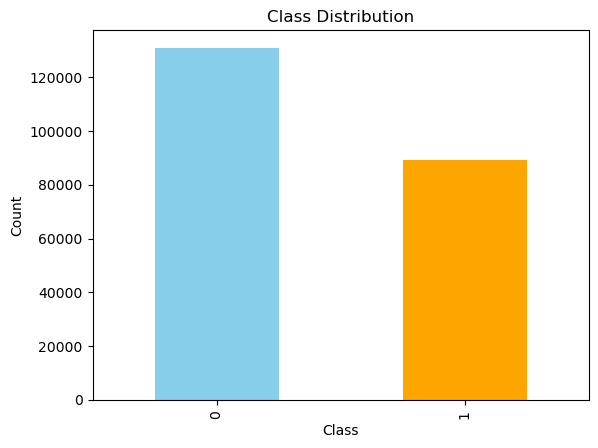

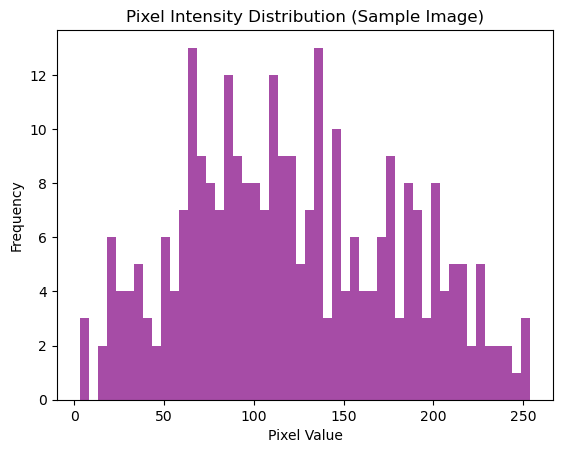

In [ ]:
# Check the distribution of labels
df['label'].value_counts().plot(kind='bar', title='Class Distribution', color=['skyblue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot histograms for pixel intensity distributions 
import numpy as np
sample_image = img[0].flatten()
plt.hist(sample_image, bins=50, color='purple', alpha=0.7)
plt.title('Pixel Intensity Distribution (Sample Image)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Dataset generator

1. We use ImageDataGenerator for real-time image loading and preprocessing.
2. Set rescale=1./255 to normalizes pixel values from [0, 255] to [0, 1], which improves model performance and convergence.
3. Set validation_split=0.15 to split the dataset, reserving 15% for validation and 85% for training.
4. Create the training data generator and validation data generator.

In [12]:
df = pd.read_csv('./input/histopathologic-cancer-detection/train_labels.csv')
df['id'] = df['id'] + '.tif'  
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_path = './input/histopathologic-cancer-detection/train/'
valid_path = './input/histopathologic-cancer-detection/train/'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='id',
    y_col='label',
    has_ext=True,
    subset='training',
    target_size=(96, 96),
    batch_size=64,
    class_mode='raw'  
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=valid_path,
    x_col='id',
    y_col='label',
    has_ext=True,
    subset='validation',
    target_size=(96, 96),
    batch_size=64,
    shuffle=False,
    class_mode='raw'  
)

Found 187022 validated image filenames.
Found 33003 validated image filenames.


# DModel Architecture

This model is a custom Convolutional Neural Network designed for binary classification, suitable for detecting cancer in histopathologic images. Here is analysis of the architecture and its components:

In [8]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

/Users/songruiming/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,313 (2.43 MB)

 Trainable params: 637,313 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Iteratively optimize the model to minimize loss and improve classification accuracy by learning features from the training dataset while monitoring performance on validation data. 

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID
)

Epoch 1/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7898 - loss: 0.4659

/Users/songruiming/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 563s 192ms/step - accuracy: 0.7898 - loss: 0.4659 - val_accuracy: 0.8563 - val_loss: 0.3385
Epoch 2/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.9375 - loss: 0.2024 - val_accuracy: 0.9302 - val_loss: 0.2399
Epoch 3/15


2024-11-14 23:47:47.159979: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/songruiming/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-14 23:47:47.211700: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3632s 1s/step - accuracy: 0.8523 - loss: 0.3456 - val_accuracy: 0.8719 - val_loss: 0.3301
Epoch 4/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.8906 - loss: 0.2390 - val_accuracy: 0.9302 - val_loss: 0.2016
Epoch 5/15


2024-11-15 00:48:19.607826: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3481s 1s/step - accuracy: 0.8753 - loss: 0.2987 - val_accuracy: 0.8511 - val_loss: 0.3420
Epoch 6/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.8906 - loss: 0.2411 - val_accuracy: 0.9302 - val_loss: 0.1698
Epoch 7/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3670s 1s/step - accuracy: 0.8945 - loss: 0.2629 - val_accuracy: 0.8970 - val_loss: 0.2624
Epoch 8/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.9375 - loss: 0.2042 - val_accuracy: 0.9535 - val_loss: 0.1215
Epoch 9/15


2024-11-15 02:47:30.342076: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3806s 1s/step - accuracy: 0.9033 - loss: 0.2445 - val_accuracy: 0.8823 - val_loss: 0.2759
Epoch 10/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.9688 - loss: 0.1256 - val_accuracy: 0.9767 - val_loss: 0.0981
Epoch 11/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3344s 1s/step - accuracy: 0.9084 - loss: 0.2354 - val_accuracy: 0.8416 - val_loss: 0.3612
Epoch 12/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.9219 - loss: 0.1534 - val_accuracy: 0.9535 - val_loss: 0.1469
Epoch 13/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3511s 1s/step - accuracy: 0.9132 - loss: 0.2272 - val_accuracy: 0.8796 - val_loss: 0.2762
Epoch 14/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.9062 - loss: 0.2110 - val_accuracy: 0.9767 - val_loss: 0.1155
Epoch 15/15
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2525s 864ms/step - accuracy: 0.9151 - loss: 0.2192 - val_accuracy: 0.8837 - val_loss: 0.2755


In [13]:
test_df = pd.read_csv('./input/histopathologic-cancer-detection/sample_submission.csv')

from matplotlib.pyplot import imread
# Kaggle testing
from glob import glob
TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join('./input/histopathologic-cancer-detection/test/','*.tif'))
submission = pd.DataFrame()
print(len(testing_files))
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
submission.to_csv('submission_new_model.csv', index=False, header=True)
print(submission.head())

57458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━

# Results and Analysis

The results are good! The CNN model has a progressive filter increase (16 → 32 → 64 → 128), enabling it to learn simple features in early layers and more complex patterns in deeper layers.
Next the dropout and max-pooling effectively reduce overfitting and dimensionality.
And binary cross-entropy is well-suited for a binary classification task, as it focuses on minimizing the log loss for the correct class.
Finally, the adaptive learning rates in Adam make it robust and well-suited for this classification problem.

In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Predict probabilities on the validation dataset
# y_true = validation_generator.classes  # True labels from the generator
# y_pred = model.predict(validation_generator, steps=STEP_SIZE_VALID)

# # Compute the false positive rate, true positive rate, and thresholds
# fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# # Compute the Area Under the Curve (AUC)
# roc_auc = auc(fpr, tpr)

# # Plot the ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
# plt.legend(loc='lower right')
# plt.grid(alpha=0.3)
# plt.show()

# Conclusion
I did the data analysis and build a model of CNN. As the ROC curve say, it is a good result.Here are the learning and takeaway.

1. Dataset Handling and Preprocessing

Data augmentation  was not initially applied but would have improved model generalization by simulating real-world variability.
Class imbalance in the dataset may lead to misleading accuracy metrics. 

2. Model Design and Architecture

The current architecture is well-suited for this binary classification task, balancing complexity and performance.
In future iterations, pre-trained models could be explored for potentially faster convergence and improved feature extraction.

3. Training Process

Incorporating learning rate schedulers or early stopping could further enhance efficiency by avoiding unnecessary epochs or fine-tuning the learning rate dynamically.
